#  任务2:使用YOLOv3进行模型训练

## 职业能力目标：

- 了解YOLOv3_tiny算法

- 学习搭建模型的方法

- 训练YOLOv3_tiny模型用来进行目标检测

## 任务描述

- 介绍YOLOv3_tiny算法，损失函数

- 训练模型进行目标检测

## 知识储备

## 1 yolov3_tiny介绍
YOLOV3-tiny就是在YOLOv3的基础上去掉了一些特征层，只保留了2个独立预测分支，所以在速度上要比YOLOv3快。具体的结构图如下

<img style="float: center;" width = "500" height = "200" src="./tmp/image/yolov3_tiny.jpeg">

## 任务实施

## 1 依赖环境安装

**将任务路径更改到`train`目录下**

In [ ]:
%cd '/home/jovyan/yolo-flask-vue/train'
!ls

In [ ]:
!sudo pip install --upgrade pip

!sudo pip install -r requirements.txt -i https://pypi.douban.com/simple

## 2 搭建yolov3-tiny模型

### 2.1 导入相关模块

模块介绍：
- `tensorflow`一个基于数据流编程的符号数学系统，被广泛应用于各类机器学习算法的编程实现，其前身是谷歌的神经网络算法库DistBelief。
- `decode_cfg`用于解码模型配置参数，如路径、模型名称等等
- `init`用于存储模型的参数
- `Header`目标检测计算方法，返回框的位置，置信度，分类等

In [ ]:
import tensorflow as tf
from core.utils.config import decode_cfg
from config import init  ##参数配置
from core.model.one_stage.yolov3.yolov3 import Header ##模型内部参数计算方法

### 2.2 读取配置文件

部分参数介绍：
- `cfg`解析的是[yolov3_tiny.yaml](./train/cfgs/yolov3_tiny.yaml)文件信息，其中：

    type: "yolov3_tiny" 使用模型类型

    iou_threshold: 0.5  IOU就是交集和并集的比值，Intersection over Union

    score_threshold: 0.4  得分阈值

    max_boxes: 100 最大boxes值

    strides: "32,16,8"  做卷积运算的步长

    anchors: "10,13 16,30 33,23 30,61 62,45 59,119 116,90 156,198 373,326"  
                                  锚定点，预选框值

    mask: "6,7,8 3,4,5 0,1,2"     预选框的参数组
- `LEAKY_ALPHA`在激活函数`tf.keras.layers.LeakyReLU`中使用，用于参数激活时给特定参数一个系数。

In [ ]:
cfg = decode_cfg(init.TRAIN.YAML_PATH)
input_size=None
WEIGHT_DECAY = 0. ##权重衰变
LEAKY_ALPHA = 0.1 ##斜率
name=None

参数介绍：
- `iou_threshold` iou为目标检测算法性能指标
- `score_threshold` score是物体检测置信度
- `max_outputs` 最大检测框数量
- `num_classes` 检测物品类别数
- `strides`两个值，分别为两个输出的缩放比例
- `mask` yolo中有初始化的框用于备选，这里有两组框作为备选
- `anchors` 预测框的初始宽高，第一个是w，第二个是h

<font color = 'red' size=3>动手练习1</font>

根据参数介绍以及设置好的参数，补充`<>`部分的参数

In [ ]:
iou_threshold = cfg["yolo"]["iou_threshold"]

In [ ]:
iou_threshold

In [ ]:
score_threshold = cfg["yolo"]["score_threshold"]
max_outputs = cfg["yolo"]["max_boxes"]
num_classes = cfg["yolo"]["num_classes"]
strides = cfg["yolo"]["strides"]
mask = <1>
anchors = <2>

执行以下代码，输出为`[3 4 5]`和`[23 27]`则填写正确

In [ ]:
print(mask[0])
print(anchors[0])

### 2.3 定义模型组件


- `DarknetConv2D_BN_Leaky(*args, **kwargs)`：是yolo模型中的基础单元，有三个部分组成即：  
  内部说明：
  - DarknetConv2D()
     - 1个Darknet的2维卷积Conv2D层，即DarknetConv2D；
  - BatchNormalization()
     - 1个正则化层函数，即BatchNormalization()；
  - LeakyReLU()
     - 1个LeakyReLU层，斜率是0.1，LeakyReLU是ReLU的变换；

**定义模型基础单元**

In [ ]:
def DarknetConv2D(*args, **kwargs):
    darknet_conv_kwargs = {"kernel_regularizer": tf.keras.regularizers.l2(WEIGHT_DECAY),
                           "kernel_initializer": tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
                           "padding": "valid" if kwargs.get(
                               "strides") == (2, 2) else "same"}
    darknet_conv_kwargs.update(kwargs)

    return tf.keras.layers.Conv2D(*args, **darknet_conv_kwargs)

In [ ]:
def DarknetConv2D_BN_Leaky(*args, **kwargs):
    without_bias_kwargs = {"use_bias": False}
    without_bias_kwargs.update(kwargs)

    def wrapper(x):
        x = DarknetConv2D(*args, **without_bias_kwargs)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=LEAKY_ALPHA)(x)
        return x

    return wrapper

**定义获取数据形状的单元**

- `PreprocessInput(tf.keras.layers.Layer)`：输入参数的预处理：  
  内部说明：
  -  __init__(self, **kwargs)
     - 保存成员变量的设置；
  - build(self, input_shape)
     - 在call()函数第一次执行时会被调用一次，这时候可以知道输入数据的shape。返回去看一看，果然是__init__()函数中只初始化了输出数据的shape，而输入数据的shape需要在build()函数中动态获取，这也解释了为什么在有__init__()函数时还需要使用build()函数；
  - call(self, inputs, **kwargs)
     - call()函数就很简单了，即当其被调用时会被执行；
  - compute_output_shape(self, input_shape)
     - 如果该层尚未构建，此方法会构建该层。这假设层稍后将与以下输入一起使用匹配这里提供的输入形状；

In [ ]:
class PreprocessInput(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(PreprocessInput, self).__init__(**kwargs)

    def build(self, input_shape):
        super(PreprocessInput, self).build(input_shape)  

    def call(self, inputs, **kwargs):
        x = tf.divide(inputs, 255.)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

**开始搭建模型**

- `MaxPool2D(pool_size=(2, 2), strides=None)`：可以加快计算速度和防止过拟合的作用。  
  参数说明：
  - `pool_size`：指定池窗口的大小。
  - `strides`：指定池操作的步幅。

- `tf.keras.layers.UpSampling2D(2)`：2D 输入的上采样层。沿着数据的行和列分别重复 size[0] 和 size[1] 次。  
  参数说明：
  - `size`：整数，或 2 个整数的元组。 行和列的上采样因子。
  - `data_format`：字符串， channels_last (默认) 或 channels_first 之一， 表示输入中维度的顺序。channels_last 对应输入尺寸为 (batch, height, width, channels)， channels_first 对应输入尺寸为 (batch, channels, height, width)。 它默认为从 Keras 配置文件 ~/.keras/keras.json 中 找到的 image_data_format 值。 如果你从未设置它，将使用 "channels_last"。
  - `interpolation`:字符串，nearest 或 bilinear 之一。 注意 CNTK 暂不支持 bilinear upscaling， 以及对于 Theano，只可以使用 size=(2, 2)。

<font color = 'red' size=3>动手练习2</font>

仔细查看模型搭建的方式，在`<1>`处`<2>`处补全模型
- `<1>`处模型参数为`DarknetConv2D_BN_Leaky(32, 3)`
- `<2>`处与其他位置一样

<img style="float: center;" width = "500" height = "200" src="./tmp/image/yolov3_tiny.jpeg">

In [ ]:
if input_size is None:
    x = inputs = tf.keras.Input([None, None, 3])
else:
    x = inputs = tf.keras.Input([input_size, input_size, 3])

x = PreprocessInput()(x)

x = DarknetConv2D_BN_Leaky(16, 3)(x)
x = tf.keras.layers.MaxPool2D(2, 2, "same")(x)
x = <1>
x = <2>
x = DarknetConv2D_BN_Leaky(64, 3)(x)
x = tf.keras.layers.MaxPool2D(2, 2, "same")(x)
x = DarknetConv2D_BN_Leaky(128, 3)(x)
x = tf.keras.layers.MaxPool2D(2, 2, "same")(x)
x = x_8 = DarknetConv2D_BN_Leaky(256, 3)(x)
x = tf.keras.layers.MaxPool2D(2, 2, "same")(x)
x = DarknetConv2D_BN_Leaky(512, 3)(x)
x = tf.keras.layers.MaxPool2D(2, 1, "same")(x)
x = DarknetConv2D_BN_Leaky(1024, 3)(x)

x = x_13 = DarknetConv2D_BN_Leaky(256, 1)(x)
x = DarknetConv2D_BN_Leaky(512, 3)(x)
output_0 = DarknetConv2D(len(mask[0]) * (num_classes + 5), 1)(x)

x = DarknetConv2D_BN_Leaky(128, 1)(x_13)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Concatenate()([x, x_8])

x = DarknetConv2D_BN_Leaky(256, 3)(x)
output_1 = DarknetConv2D(len(mask[1]) * (num_classes + 5), 1)(x)

- `tf.keras.Model`：在函数式 API 中，给定一些输入张量和输出张量，可以通过以下方式实例化一个 Model
  参数说明：
  - `inputs`：模型的输入:一个keras的输入的对象或列表。
  - `outputs`：模型的输出。
  - `name`:字符串，模型的名称。


In [ ]:
model = tf.keras.Model(inputs, (output_0, output_1), name=name)

outputs = Header(num_classes, anchors, mask, strides, max_outputs, iou_threshold, score_threshold)(
    (output_0, output_1))

eval_model = tf.keras.Model(inputs, outputs, name=name)


执行以下代码，最后参数输出为

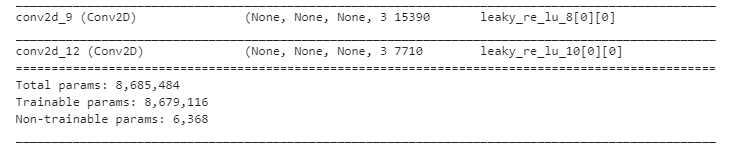

则动手练习2填写正确

In [ ]:
model.summary()

## 3.训练准备

### 3.1 导入必要的包和模块

In [ ]:
import os ##操作系统模块
import time  ##时间模块
from absl import app, flags  
from tensorflow.keras import optimizers  ##优化器
from core.utils import decode_cfg, load_weights  ##解析参数函数，加载模型权重函数
from core.dataset import Dataset  ##数据集
from core.callbacks import COCOEvalCheckpoint, CosineAnnealingScheduler, WarmUpScheduler  ##评估模型存储模型回调函数、学习率调整回调函数、预训练回调函数
from core.utils.optimizers import Accumulative ##优化器生成函数
from config import init  ##参数配置
from core.model.one_stage.yolov3 import YOLOv3_Tiny as Model ##yolov3模型
from core.model.one_stage.yolov3 import YOLOLoss as Loss  ##损失率函数


### 3.2设置参数，读取配置

<font color=red size=3>动手练习3</font>

通过读取[config.py](./train/config.py)配置文件参数来定义参数

- 请在`<1>`中写出训练数据集的长度
- `<2>`填写代码实现读取`init`模块中的训练迭代次数`TRAIN.EPOCHS`参数

In [ ]:
num = 29  ##网络层数
cfg = decode_cfg(init.TRAIN.YAML_PATH) ##读取并解析yolov3——tiny配置文件
train_dataset = Dataset(cfg) ##获取训练集数据
epoch_steps = <1>  ##训练数据集长度
epochs = <2>    #从配置中读取训练迭代次数

执行以下代码，输出为`100 20`则填写正确

In [ ]:
print(epoch_steps)
print(epochs)

### 3.3从yolov3_tiny.yaml配置文件中读取数据，加载权重
<font color=red size=3>动手练习4</font>

在`<1>`中使用`load_weights`方法写出加载模型权重
- `load_weights(model, weight)`
    - 参数1为要导入的模型，这里是`model`
    - 参数2为要导入的权重，这里是`init_weight`

In [ ]:
init_weight = init.TRAIN.INIT_WEIGHT_PATH    #载入预训练权重路径
anchors = cfg['yolo']['anchors'] ##预选框
mask = cfg['yolo']['mask']  ##预选矿的序列范围
strides = cfg['yolo']['strides']  ##步长
ignore_threshold = cfg['train']['ignore_threshold'] ##丢失阈值
loss_type = cfg['train']['loss_type'] ##损失函数类型

if init_weight:              ##加载模型
    <1>
else:
    print("Training from scratch")
    num = 0

### 3.4创建损失函数
- `Loss(anchors, stride, num_classes, ignore_thresh, type)`：实例化损失函数
  参数说明：
  - `anchors`：锚定点，预选框值。
  - `stride`：步长。
  - `num_classes`:类型数量。
  - `ignore_thresh`：忽略阈值。
  - `type`:函数类型。


我们对每个锚定点的每个预选框都求一个损失值：

In [ ]:
loss = [Loss(anchors[mask[i]],
             strides[i],
             train_dataset.num_classes,
             ignore_threshold,
             loss_type) for i in range(len(mask))]

####  创建模型权重文件保存路径，加上标签，加上时间戳

In [ ]:
ckpt_path = os.path.join(init.TRAIN.SAVE_WEIGHT_PATH, 'tmp', cfg["train"]["label"],
                         time.strftime("%Y%m%d%H%M", time.localtime()))

### 3.5模型预热训练回调函数

- `WarmUpScheduler`：带有预热学习率调度器的余弦衰减构造器
  参数说明：
  - `learning_rate`：基础学习速率。
  - `warmup_step`：热身步骤数。(默认值:{0})。
  - `global_step_init`:初始全局步骤，例如来自前一个检查点。
  - `learning_rate_init`：初始学习速度为热身。(默认值:{0.0})。
  - `verbose`: 0:表示安静，1:表示更新消息。(默认值:{1})。
  
  

<font color=red size=3>动手练习5</font>

请在`<1>`填写配置文件中模型预热学习率参数`init.TRAIN.WARMUP_LEARN_RATE`

`<2>`填写配置文件中模型预热训练次数`init.TRAIN.WARMUP_EPOCHS * epoch_steps`

In [ ]:
warmup_callback = [WarmUpScheduler(learning_rate=<1>, warmup_step=<2>, verbose=1)]

填写完成后执行以下代码，输出结果类似：

`[<core.callbacks.lrschedular.WarmUpScheduler at 0x7f321d4b2a50>]`

说明填写正确。

In [ ]:
warmup_callback

### 3.6模型评估回调函数--进行存储模型

- `COCOEvalCheckpoint`：评估模型回调函数用于存储模型
  参数说明：
  - `save_path`：存储路径。
  - `eval_model`：评估模型。
  - `model_cfg`:模型配置。
  - `only_save_weight`：是否只存储权重值。
  - `verbose`: 0:表示安静，1:表示更新消息。(默认值:{1})。
  

In [ ]:
eval_callback = [COCOEvalCheckpoint(save_path=os.path.join(ckpt_path,init.TRAIN.SAVE_NAME),
                                        eval_model=eval_model,
                                        model_cfg=cfg,
                                        verbose=1)]

### 3.7模型评估回调函数--修改训练学习率

- `CosineAnnealingScheduler`：评估模型回调函数用于存储模型
  参数说明：
  - `learning_rate`：学习速率。
  - `T_max`：总迭代次数。
  - `eta_min`:最小学习率。
  - `verbose`: 0:表示安静，1:表示更新消息。(默认值:{1})。

In [ ]:
lr_callback = [CosineAnnealingScheduler(learning_rate=init.TRAIN.LEARN_RATE_INIT,
                                            eta_min=init.TRAIN.LEARN_RATE_END,
                                            T_max=epochs * epoch_steps,
                                            verbose=1)]

### 3.8判断模型权重文件保存路径是否存在，不存在则创建

In [ ]:
if not os.path.isdir(ckpt_path):
    os.makedirs(ckpt_path)
    os.makedirs(os.path.join(ckpt_path, 'train', 'plugins', 'profile'))

###  3.9定义优化器
- `Adam(learning_rate)`：优化算法  
  参数说明：
  - `learning_rate`：学习率。将输出误差反向传播给网络参数，以此来拟合样本的输出。本质上是最优化的一个过程，逐步趋向于最优解。

In [ ]:
opt = Accumulative(optimizers.Adam(lr=0.), 16)

## 4 开始训练
### 4.1冻结预训练模型层参数

预训练模型层总共29层，设定`model.layers[i].trainable = False`将他们冻结。

In [ ]:
for i in range(num):
    model.layers[i].trainable = False
    print(model.layers[i].name)
print('Freeze the first {} layers of total {} layers.'.format(num, len(model.layers)))

### 4.2预热训练

`compile`主要完成损失函数和优化器的一些配置，是为训练服务的。
`fit`函数返回一个`History`的对象，其`History.history`属性记录了损失函数和其他指标的数值随`epoch`变化的情况，如果有验证集的话，也包含了验证集的这些指标变化情况

<font color=red size=3>动手练习6</font>



- `model.compile(optimizer,loss,run_eagerly)`：用于在配置训练方法时，告知训练时用的优化器、损失函数和准确率评测标准。  
  参数说明：
  - `optimizer`：优化器
  - `loss`：损失函数；多分类损失函数有：二分类交叉熵损失函数`binary_crossentropy`、多类别交叉熵损失函数`categorical_crossentropy`
  - `run_eagerly`：默认为“False”。如果“True”，则为“Model”逻辑不会封装在' tf.function '中。建议离开除非你的“模型”不能“tf.function”。
  
  
- `model.fit`：以给定数量的轮次（数据集上的迭代）训练模型。  
  参数说明：
  - `batch_size`：每次梯度更新的样本数。如果未指定，默认为 32。
  - `steps_per_epoch`：在声明一个轮次完成并开始下一个轮次之前的总步数（样品批次）。 使用 TensorFlow 数据张量等输入张量进行训练时，默认值 None 等于数据集中样本的数量除以 batch 的大小，如果无法确定，则为 1。
  - `epochs`：训练模型迭代轮次。一个轮次是在整个 x 和 y 上的一轮迭代。 请注意，与 initial_epoch 一起，epochs 被理解为 「最终轮次」。模型并不是训练了 epochs 轮，而是到第 epochs 轮停止训练。
  - `callbacks`：一系列的 keras.callbacks.Callback 实例。一系列可以在训练时使用的回调函数。 详见 callbacks。
  - `verbose`：0 或 1。日志显示模式。 0 = 安静模式，1 = 进度条。
  
  
- 请在`<1>`填写损失函数`loss`
- `<2>`填写优化器`opt`

In [ ]:
model.compile(<1>, <2>, run_eagerly=False)
model.fit(train_dataset,
          steps_per_epoch=epoch_steps,
          epochs=1,
          callbacks=warmup_callback,
          verbose=1
          )


若能够顺利运行，这说明代码填写正确

### 4.3第一阶段训练
专门训练模型的分类能力

In [ ]:
model.compile(loss=loss, optimizer=opt, run_eagerly=False)
model.fit(train_dataset,
          steps_per_epoch=epoch_steps,
          epochs=epochs // 5 * 2,
          callbacks=eval_callback + lr_callback,
          verbose=1
          )

### 4.4释放模型层参数

In [ ]:
for i in range(len(model.layers)): model.layers[i].trainable = True
print('Unfreeze all layers.')

### 4.5第二阶段训练
训练所有模型层参数

**注意，执行训练脚本花费的时间比较长，可能达到30分钟以上，设置较小的epochs，如设置`epochs=2`来进行训练**

In [ ]:
model.compile(loss=loss, optimizer=opt, run_eagerly=False)
model.fit(train_dataset,
          steps_per_epoch=epoch_steps,
          epochs=epochs // 5 * 3,
          callbacks=eval_callback + lr_callback,
          verbose=1
          )

### 4.6 使用模型预测


In [ ]:
from absl import app, flags
from core.utils import decode_cfg, load_weights
from core.image import draw_bboxes, preprocess_image, postprocess_image, read_image, read_video, Shader
import time
import cv2
import numpy as np
from config import init
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

In [ ]:
def inference(image,model):

    h, w = image.shape[:2]
    image = preprocess_image(image, (416, 416)).astype(np.float32)
    images = np.expand_dims(image, axis=0)

    tic = time.time()
    bboxes, scores, classes, valid_detections = model.predict(images)
    toc = time.time()

    bboxes = bboxes[0][:valid_detections[0]]
    scores = scores[0][:valid_detections[0]]
    classes = classes[0][:valid_detections[0]]

    # bboxes *= image_size
    _, bboxes = postprocess_image(image, (w, h), bboxes)

    return (toc - tic) * 1000, bboxes, scores, classes

<font color=red size=3>动手练习7</font>

请在`<1>`填写需要检测的图片路径，图片在`./data/supermarket/img`中。

In [ ]:
image = read_image(<1>)
shader = Shader(init.TRAIN.NUM_CLASSES)
names = init.XML.LABELS
ms, bboxes, scores, classes = inference(image,eval_model)
image = draw_bboxes(image, bboxes, scores, classes, names, shader)
plt.imshow(image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()